In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
!ls "/content/drive/My Drive/Data"

base_model.h5		       train
densenet-100_sample.h5	       unique_20_sample_test
densenet_2_dropout.h5	       unique_20_sample_train
densenet_img_aug.h5	       unique_5_sample_test
model_5_1.h5		       unique_5_sample_train
model_cnn_noaug_70%.h5	       vgg_1dropout.h5
model_weights_densenet_85%.h5  vgg_1dropout_new.h5
resnet_dropout_model1.h5       vgg_20size.h5
resnet_dropout_model2.h5       vgg_baseline.h5
resnet_dropout_model3.h5       vgg_imgaug_base2.h5
resnet_dropout_model4.h5       vgg_imgaug_base.h5
resnet_samplesize_model1.h5    vgg_imgaug.h5
resnet_samplesize_model3.h5    vizgradcam
resnet_withaug_model2_.h5      xception_1dropout.h5
test			       xception_main.h5


In [3]:
train_data_dir = "/content/drive/My Drive/Data/train"
test_data_dir = "/content/drive/My Drive/Data/test"

In [4]:
# Print Graphs (training vs testing)
def plotting(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_' + string])
    plt.ylabel(string)
    plt.xlabel("Epochs")
    plt.legend([string, "val_"+string])
    plt.show()

In [5]:
Pneumona_img = os.listdir(train_data_dir + "/PNEUMONIA")
Normal_img = os.listdir(train_data_dir + "/NORMAL")
COVID19_img = os.listdir(train_data_dir + "/COVID19")

In [6]:
# To Tackle Issue of Imbalanced Dataset during Model Fitting
pneumonia_cases = len(Pneumona_img)
normal_cases = len(Normal_img)
covid_cases = len(COVID19_img)

pneumonia_weight = pneumonia_cases / (pneumonia_cases + normal_cases + covid_cases)
normal_weight = normal_cases / (pneumonia_cases + normal_cases + covid_cases)
covid_weight = covid_cases / (pneumonia_cases + normal_cases + covid_cases)

class_weight = {0: covid_weight, 1: normal_weight,
                2: pneumonia_weight}

print(f"Weight for class 0: {covid_weight:.2f}")
print(f"Weight for class 1: {normal_weight:.2f}")
print(f"Weight for class 2: {pneumonia_weight:.2f}")

Weight for class 0: 0.22
Weight for class 1: 0.21
Weight for class 2: 0.57


In [7]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from numpy.random import seed
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, Softmax, Dropout
from tensorflow.keras.layers import AveragePooling2D, BatchNormalization
from tensorflow.keras.layers import MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
import tensorflow
import pandas as pd

%matplotlib inline
from glob import glob

In [9]:
img_size = [224, 224]
train_datagen = ImageDataGenerator(rescale = 1./224,
                                   rotation_range=140,
                                   width_shift_range=0.1,
                                   zoom_range=0.2,
                                   brightness_range=[0.2,1.0]
                                   )

test_datagen = ImageDataGenerator(rescale = 1./224)

train_generator = train_datagen.flow_from_directory(directory = train_data_dir,
                                                        target_size = tuple(img_size),
                                                        batch_size = 8,
                                                        shuffle = True,
                                                        class_mode = 'categorical')

test_generator = test_datagen.flow_from_directory(directory = test_data_dir,
                                                        target_size = tuple(img_size),
                                                        batch_size = 1,
                                                        class_mode = 'categorical',
                                                        shuffle = False)

Found 6033 images belonging to 3 classes.
Found 1288 images belonging to 3 classes.


In [10]:
pretrained_mobilenet = tf.keras.applications.mobilenet_v2.MobileNetV2(input_shape = img_size + [3], weights='imagenet', include_top=False)

for layer in pretrained_mobilenet.layers:
    layer.trainable = False

9420800/9406464 [==============================] - 0s 0us/step


In [11]:
model =  MaxPooling2D(pool_size = (2, 2), 
                               strides = 1, padding = 'valid')(pretrained_mobilenet.output)
model = Flatten()(model)

model = Dense(units = 256, activation = 'relu')(model)
model = Dense(units = 128, activation = 'relu')(model)
model = Dense(units = 64, activation = 'relu')(model)


# Stick with 3 because 3 different classes to be predicted
predictions = Dense(units = 3, activation = 'softmax')(model)
model = Model(inputs = pretrained_mobilenet.input, outputs = predictions)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
______________________________________________________________________________________________

In [12]:
opt = Adam(learning_rate=0.001, decay=1e-6)
model.compile(optimizer = opt, 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

In [13]:
CheckPointCallback = ModelCheckpoint("mobilenet_imgaug.h5", monitor='val_accuracy',save_best_only=True, mode='max',verbose=1)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=8)

In [14]:
seed(1)
tensorflow.random.set_seed(2)

history = model.fit(train_generator,
                    epochs = 25,
                    batch_size = 16,
                    validation_data= test_generator,
                    class_weight = class_weight,
                    callbacks = [CheckPointCallback, es],
                    verbose = 1)

Epoch 1/25
755/755 [==============================] - 4178s 5s/step - loss: 0.5024 - accuracy: 0.7973 - val_loss: 0.5456 - val_accuracy: 0.7554

Epoch 00001: val_accuracy improved from -inf to 0.75543, saving model to mobilenet_imgaug.h5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/25
755/755 [==============================] - 274s 363ms/step - loss: 0.1255 - accuracy: 0.8487 - val_loss: 0.5287 - val_accuracy: 0.8160

Epoch 00002: val_accuracy improved from 0.75543 to 0.81599, saving model to mobilenet_imgaug.h5
Epoch 3/25
755/755 [==============================] - 274s 363ms/step - loss: 0.1141 - accuracy: 0.8669 - val_loss: 0.2523 - val_accuracy: 0.9045

Epoch 00003: val_accuracy improved from 0.81599 to 0.90450, saving model to mobilenet_imgaug.h5
Epoch 4/25
755/755 [==============================] - 268s 355ms/step - loss: 0.0926 - accuracy: 0.8807 - val_loss: 0.2005 - val_accuracy: 0.9231

Epoch 00004: val_accuracy improved from 0.90450 to 0.92314, saving model to mobilenet_imgaug.h5
Epoch 5/25
755/755 [==============================] - 268s 356ms/step - loss: 0.0847 - accuracy: 0.8878 - val_loss: 0.4950 - val_accuracy: 0.8106

Epoch 00005: val_accuracy did not improve from 0.92314
Epoch 6/25
755/755 [==============================] - 267s 354ms/step

In [15]:
evaluation = model.evaluate(test_generator)
print(f"Test Accuracy: {evaluation[1] * 100:.2f}%")

evaluation = model.evaluate(train_generator)
print(f"Train Accuracy: {evaluation[1] * 100:.2f}%")

1288/1288 [==============================] - 45s 35ms/step - loss: 0.3698 - accuracy: 0.8602
Test Accuracy: 86.02%
755/755 [==============================] - 238s 315ms/step - loss: 0.2249 - accuracy: 0.9246
Train Accuracy: 92.46%


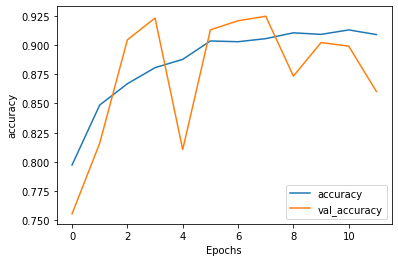

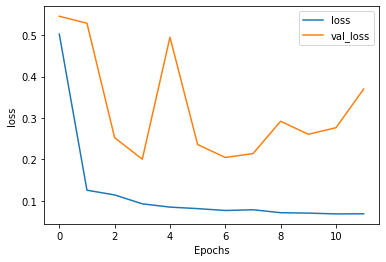

In [16]:
plotting(history, "accuracy")
plotting(history, "loss")

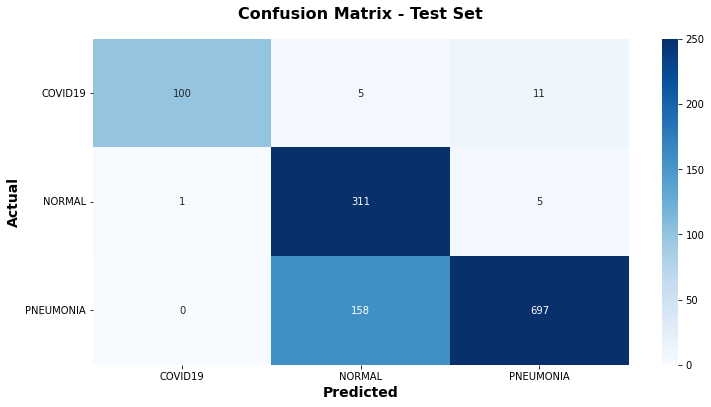

In [17]:
classes = ['COVID19', 'NORMAL', 'PNEUMONIA']

pred_class = model.predict(test_generator)
predictions = np.array(list(map(lambda x: np.argmax(x), pred_class)))

y_true= test_generator.classes

CMatrix = pd.DataFrame(confusion_matrix(y_true, predictions), columns=classes, index =classes)

plt.figure(figsize=(12, 6))
ax = sns.heatmap(CMatrix, annot = True, fmt = 'g' ,vmin = 0, vmax = 250,cmap = 'Blues')
ax.set_xlabel('Predicted',fontsize = 14,weight = 'bold')
ax.set_xticklabels(ax.get_xticklabels(),rotation =0);

ax.set_ylabel('Actual',fontsize = 14,weight = 'bold') 
ax.set_yticklabels(ax.get_yticklabels(),rotation =0);
ax.set_title('Confusion Matrix - Test Set',fontsize = 16,weight = 'bold',pad=20);